In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.getcwd( )
os.chdir('/Users/jakemcgrath/Downloads')
os.getcwd( )


'/Users/jakemcgrath/Downloads'

In [24]:
Re = 600 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../downloads/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

Velocity field data has shape: (3000, 256, 128, 2)


In [27]:
## Make an interactive video (optional; requires ipywidgets and has some RAM overhead)

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    vscale = np.percentile(np.abs(vort_field[i]), 98)
    plt.imshow(
        vort_field[i],
        vmin=-vscale, vmax=vscale, cmap="RdBu"
    )
    plt.show()
interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(vort_field) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

<function __main__.plotter(i)>

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin

# We are going to use class inheritance to define our object. The two base classes from
# scikit-learn represent placeholder objects for working with datasets. They include 
# many generic methods, like fetching parameters, getting the data shape, etc.
# 
# By inheriting from these classes, we ensure that our object will have access to these
# functions, even though we don't have to define them ourselves
class PrincipalComponents(BaseEstimator, TransformerMixin):
    """
    A class for performing principal component analysis on a dataset.
    """

    def __init__(self, random_state=None):
        self.random_state = random_state
        self.components_ = None
        self.singular_values_ = None

    def fit(self, X):
        """
        Fit the PCA model to the data X. Store the eigenvectors in the attribute
        self.components_ and the eigenvalues in the attribute self.singular_values_
        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be fit.
        
        Returns:
            self (PrincipalComponents): The fitted object.
        """
        
        Xc = X - np.mean(X, axis=0)
        cov = Xc.T.dot(Xc) / Xc.shape[0]
        S, V = np.linalg.eigh(cov)
        V = V.T
        
        sort = np.argsort(S)[::-1]
        S = S[sort]
        V = V[sort]

        self.components_ = V
        self.singular_values_ = S

        return self

    def transform(self, X):
        """
        Transform the data X into the new basis using the PCA components
        """
        Xc = X - np.mean(X, axis=0)
        x_temp = Xc.dot(self.components_.T)
        return x_temp

    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original space
        """
        x_temp = X.dot(self.components_)
        x_temp = x_temp + np.mean(X, axis=0)
        return x_temp

Text(0, 0.5, 'Eigenvalue rank')

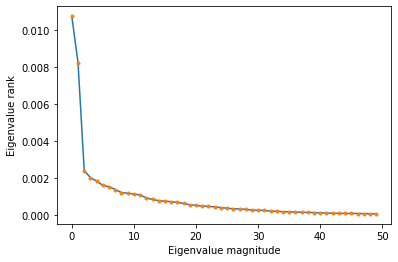

In [38]:
data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.fit_transform(data_reshaped)
principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

Text(0.5, 0, 'Time')

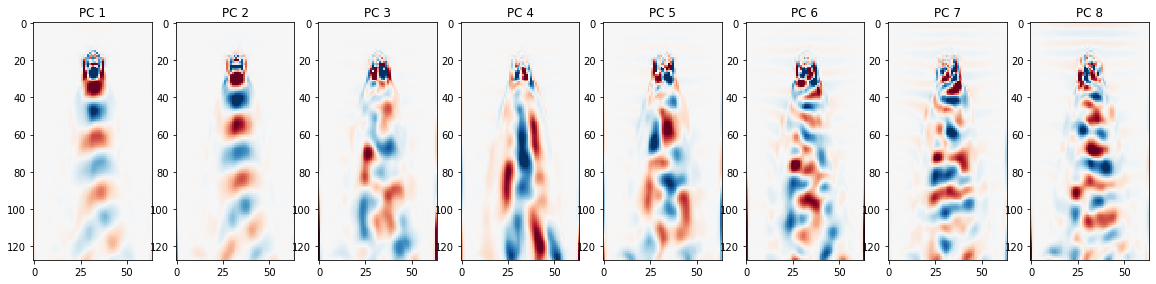

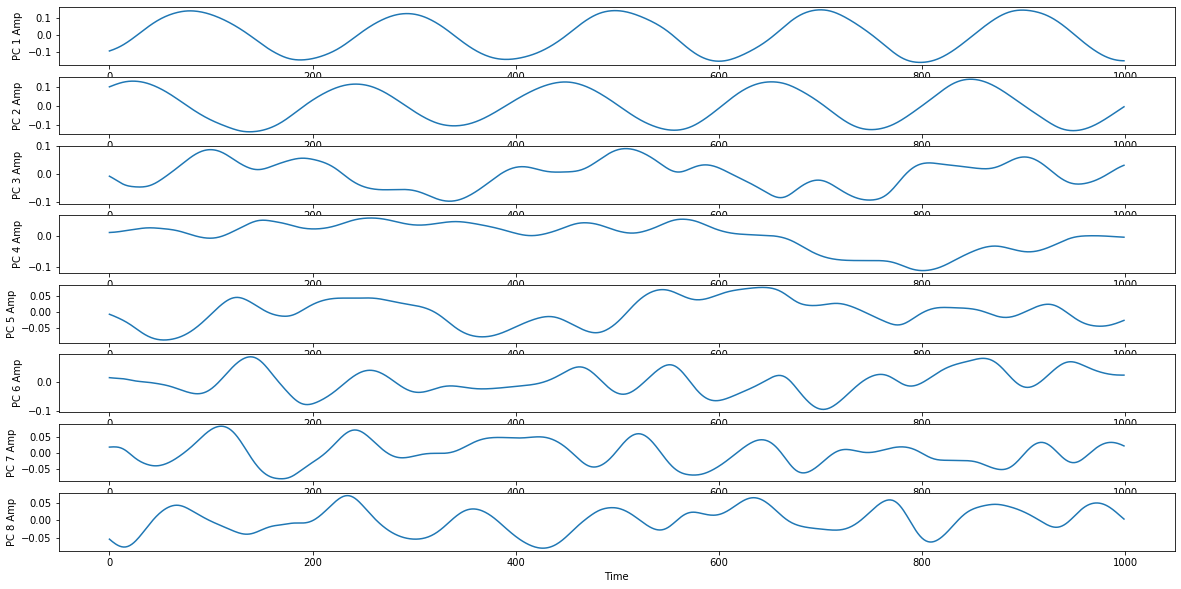

In [39]:
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

#plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])